In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from keras import backend as K
from keras.engine.topology import Layer

/Users/asmart5/python/nlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Concatenate
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras import objectives

In [4]:
class ScaleNormalizer(Layer):
    def __init__(self, **kwargs):
        super(ScaleNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, out_scale, mask=None):
        # softmax to normalize the scaling so this is a probability distribution 
        # these need to sum to 1, as they scale a guassian normal functions which have area 1
        max_scale = K.max(out_scale, axis=1, keepdims=True)
        out_scale = out_scale - max_scale
        out_scale = K.exp(out_scale)
        sum_scale = K.sum(out_scale, axis=1, keepdims=True)
        out_scale =  out_scale / sum_scale
        return out_scale
    
    def compute_output_shape(self, inputShape):
        return inputShape    
        
class MuNormalizer(Layer):
    def __init__(self, numComponents=None, outputDim=None, **kwargs):
        self.numComponents=numComponents
        self.outputDim=outputDim
        super(MuNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, mu, mask=None):
        # means so whatever is ok
        return mu
    
    def compute_output_shape(self, inputShape):
        return inputShape

class SigmaNormalizer(Layer):
    def __init__(self, **kwargs):
        super(SigmaNormalizer, self).__init__(**kwargs)

    def build(self, inputShape):
        self.size = inputShape[1]
    
    def call(self, out_sigma, mask=None):
        # sigma *must* be positive, hit it with an expodential which is always >0
        # this will give it prior bias as well
        out_sigma = K.exp(out_sigma)
        return out_sigma
    
    def compute_output_shape(self, inputShape):
        return inputShape

In [5]:
class ProbabilityLayer(Layer):
    def calc_normal(self, x, scale, mu, sigma):
        const = 1 / math.sqrt(2*math.pi)
        var =  (1 / (sigma + 1e-8))
        
        result = x - mu
        result = result * var
        result = -K.square(result)/2
        result = K.exp(result) 
        result = result * scale * var * const

        return result
        
    def __init__(self, **kwargs):
        super(ProbabilityLayer, self).__init__(**kwargs)

    def build(self, inputShapes):
        pass

    def call(self, params, mask=None):
        target = params[0] 
        scale  = params[1] 
        mu     = params[2]
        sigma  = params[3]
        
        result = self.calc_normal(target, scale, mu, sigma)
        result = K.sum(result, axis=1, keepdims=True)
        
        return result
    
    def compute_output_shape(self, inputShapes):
        return (inputShapes[0][0], 1)

In [6]:
numComponents=24
outputDim=1

# network to learn the mixture params 
i = Input(shape=(1,))
x = Dense(128)(i)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(numComponents*3)(x)

# now splice it up into the mixture params
scale = Lambda(lambda x: x[:,:numComponents],                output_shape=(numComponents,))(x)
mu    = Lambda(lambda x: x[:,numComponents:2*numComponents], output_shape=(numComponents,))(x)
sigma = Lambda(lambda x: x[:,2*numComponents:],              output_shape=(numComponents,))(x)

# correct the params into the right ranges/priors
scale = ScaleNormalizer()(scale)
mu    = MuNormalizer(numComponents=numComponents, outputDim=outputDim)(mu)
sigma = SigmaNormalizer()(sigma)

# give us an output tap on the params so we can get an idea of the sanity if needed
model_mix_settings = Model(inputs=i, outputs=[scale,mu,sigma])

# now add the layers that computes probility out from the the mixture functions at the (x,y) point
o = Input(shape=(1,))
x = ProbabilityLayer()([o,scale,mu,sigma])

model_train = Model(inputs=[i,o], outputs=x)
model_train.summary()

opt = Adam(lr=0.001)
model_train.compile(loss='binary_crossentropy',optimizer=opt)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          256         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [7]:
sampleSize=2000

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, sampleSize))).T
r_data = np.float32(np.random.normal(size=(sampleSize,1)))
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

In [8]:
target = np.ones((y_data.shape[0], 1))

In [9]:
hist = model_train.fit([x_data, y_data], target, batch_size=x_data.size, epochs=10000, verbose=1)

Epoch 1/10000
2000/2000 [==============================] - 0s 218us/step - loss: 9.5893
Epoch 2/10000
2000/2000 [==============================] - 0s 8us/step - loss: 8.3458
Epoch 3/10000
2000/2000 [==============================] - 0s 9us/step - loss: 7.6128
Epoch 4/10000
2000/2000 [==============================] - 0s 9us/step - loss: 7.0174
Epoch 5/10000
2000/2000 [==============================] - 0s 8us/step - loss: 6.5786
Epoch 6/10000
2000/2000 [==============================] - 0s 8us/step - loss: 6.2096
Epoch 7/10000
2000/2000 [==============================] - 0s 8us/step - loss: 5.8731
Epoch 8/10000
2000/2000 [==============================] - 0s 9us/step - loss: 5.5779
Epoch 9/10000
2000/2000 [==============================] - 0s 8us/step - loss: 5.3276
Epoch 10/10000
2000/2000 [==============================] - 0s 8us/step - loss: 5.1158
Epoch 11/10000
2000/2000 [==============================] - 0s 8us/step - loss: 4.9379
Epoch 12/10000
2000/2000 [========================

Epoch 96/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.8719
Epoch 97/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.8647
Epoch 98/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.8567
Epoch 99/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.8480
Epoch 100/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.8370
Epoch 101/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.8289
Epoch 102/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.8235
Epoch 103/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.8180
Epoch 104/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.8131
Epoch 105/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.8099
Epoch 106/10000
2000/2000 [==============================] - 0s 10us/step - loss: 2.8071
Epoch 107/10000
2000/2000 [========

2000/2000 [==============================] - 0s 10us/step - loss: 2.1198
Epoch 190/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.1370
Epoch 191/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.1099
Epoch 192/10000
2000/2000 [==============================] - 0s 10us/step - loss: 2.0888
Epoch 193/10000
2000/2000 [==============================] - 0s 11us/step - loss: 2.0850
Epoch 194/10000
2000/2000 [==============================] - 0s 11us/step - loss: 2.0648
Epoch 195/10000
2000/2000 [==============================] - 0s 9us/step - loss: 2.0225
Epoch 196/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.0002
Epoch 197/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.9708
Epoch 198/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.9667
Epoch 199/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.9360
Epoch 200/10000
2000/2000 [=================

2000/2000 [==============================] - 0s 9us/step - loss: 1.7515
Epoch 283/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7507
Epoch 284/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.7499
Epoch 285/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7490
Epoch 286/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7481
Epoch 287/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7472
Epoch 288/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.7463
Epoch 289/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.7454
Epoch 290/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.7444
Epoch 291/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7435
Epoch 292/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7425
Epoch 293/10000
2000/2000 [===================

2000/2000 [==============================] - 0s 8us/step - loss: 1.6478
Epoch 376/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.6542
Epoch 377/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.6742
Epoch 378/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.6476
Epoch 379/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7171
Epoch 380/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.6925
Epoch 381/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.7108
Epoch 382/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.6686
Epoch 383/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7246
Epoch 384/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.7183
Epoch 385/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.6766
Epoch 386/10000
2000/2000 [====================

2000/2000 [==============================] - 0s 8us/step - loss: 1.6261
Epoch 469/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.6187
Epoch 470/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.6004
Epoch 471/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.6037
Epoch 472/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5977
Epoch 473/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5992
Epoch 474/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5815
Epoch 475/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5830
Epoch 476/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5845
Epoch 477/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5668
Epoch 478/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5711
Epoch 479/10000
2000/2000 [=====================

Epoch 562/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5333
Epoch 563/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5335
Epoch 564/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5337
Epoch 565/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5330
Epoch 566/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5329
Epoch 567/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.5333
Epoch 568/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5332
Epoch 569/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5320
Epoch 570/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5332
Epoch 571/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5368
Epoch 572/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5331
Epoch 573/10000
2000/2000 [

Epoch 655/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5218
Epoch 656/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5200
Epoch 657/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5185
Epoch 658/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5183
Epoch 659/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5196
Epoch 660/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5221
Epoch 661/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5214
Epoch 662/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5198
Epoch 663/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5196
Epoch 664/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5197
Epoch 665/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5191
Epoch 666/10000
2000/2000 [=====

Epoch 748/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5186
Epoch 749/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5192
Epoch 750/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5129
Epoch 751/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5095
Epoch 752/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5120
Epoch 753/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5114
Epoch 754/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5107
Epoch 755/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5107
Epoch 756/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5119
Epoch 757/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5128
Epoch 758/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5145
Epoch 759/10000
2000/2000 [====

2000/2000 [==============================] - 0s 8us/step - loss: 1.5183
Epoch 842/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5112
Epoch 843/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5043
Epoch 844/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.5046
Epoch 845/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5104
Epoch 846/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5140
Epoch 847/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5098
Epoch 848/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5065
Epoch 849/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5067
Epoch 850/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5084
Epoch 851/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5071
Epoch 852/10000
2000/2000 [===================

Epoch 935/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5024
Epoch 936/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4996
Epoch 937/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.4976
Epoch 938/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4972
Epoch 939/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4983
Epoch 940/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5004
Epoch 941/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5018
Epoch 942/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5031
Epoch 943/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5030
Epoch 944/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5008
Epoch 945/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4989
Epoch 946/10000
2000/2000 [=====

Epoch 1028/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4986
Epoch 1029/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.4956
Epoch 1030/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4937
Epoch 1031/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4936
Epoch 1032/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4954
Epoch 1033/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.4983
Epoch 1034/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5015
Epoch 1035/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.5056
Epoch 1036/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5039
Epoch 1037/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.5009
Epoch 1038/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4948
Epoch 1039/10000
200

2000/2000 [==============================] - 0s 7us/step - loss: 1.4919
Epoch 1121/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4913
Epoch 1122/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4912
Epoch 1123/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4914
Epoch 1124/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4918
Epoch 1125/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4920
Epoch 1126/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4922
Epoch 1127/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4916
Epoch 1128/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4910
Epoch 1129/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4903
Epoch 1130/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.4900
Epoch 1131/10000
2000/2000 [==========

Epoch 1213/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.5677
Epoch 1214/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.5125
Epoch 1215/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.4847
Epoch 1216/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.4558
Epoch 1217/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.4502
Epoch 1218/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.4723
Epoch 1219/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5995
Epoch 1220/10000
2000/2000 [==============================] - 0s 8us/step - loss: 2.7150
Epoch 1221/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.5110
Epoch 1222/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.6637
Epoch 1223/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.7589
Epoch 1224/10000
2

Epoch 1305/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2725
Epoch 1306/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2720
Epoch 1307/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2714
Epoch 1308/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2711
Epoch 1309/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2711
Epoch 1310/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2707
Epoch 1311/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2703
Epoch 1312/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2702
Epoch 1313/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2701
Epoch 1314/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2697
Epoch 1315/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2694
Epoch 1316/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2612
Epoch 1398/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2608
Epoch 1399/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2605
Epoch 1400/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2602
Epoch 1401/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2601
Epoch 1402/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2600
Epoch 1403/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2602
Epoch 1404/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2602
Epoch 1405/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2601
Epoch 1406/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2597
Epoch 1407/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2594
Epoch 1408/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 7us/step - loss: 1.2564
Epoch 1490/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2552
Epoch 1491/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2546
Epoch 1492/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2545
Epoch 1493/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2548
Epoch 1494/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2556
Epoch 1495/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2575
Epoch 1496/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2601
Epoch 1497/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2656
Epoch 1498/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2651
Epoch 1499/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2628
Epoch 1500/10000
2000/2000 [==========

Epoch 1582/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2596
Epoch 1583/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2548
Epoch 1584/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2525
Epoch 1585/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2554
Epoch 1586/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2597
Epoch 1587/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2577
Epoch 1588/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2560
Epoch 1589/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2531
Epoch 1590/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2517
Epoch 1591/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2516
Epoch 1592/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2526
Epoch 1593/10000
200

2000/2000 [==============================] - 0s 7us/step - loss: 1.2497
Epoch 1675/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2507
Epoch 1676/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2540
Epoch 1677/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2546
Epoch 1678/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2555
Epoch 1679/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2532
Epoch 1680/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2516
Epoch 1681/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2497
Epoch 1682/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2488
Epoch 1683/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2495
Epoch 1684/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2507
Epoch 1685/10000
2000/2000 [==========

Epoch 1767/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2465
Epoch 1768/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2471
Epoch 1769/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2489
Epoch 1770/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2517
Epoch 1771/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2585
Epoch 1772/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2626
Epoch 1773/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2700
Epoch 1774/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2546
Epoch 1775/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2500
Epoch 1776/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2590
Epoch 1777/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2571
Epoch 1778/10000
20

Epoch 1859/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2430
Epoch 1860/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2429
Epoch 1861/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2430
Epoch 1862/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2427
Epoch 1863/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2427
Epoch 1864/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2428
Epoch 1865/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2429
Epoch 1866/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2427
Epoch 1867/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2427
Epoch 1868/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2427
Epoch 1869/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2429
Epoch 1870/10000
2000

2000/2000 [==============================] - 0s 9us/step - loss: 1.2400
Epoch 1952/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2396
Epoch 1953/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2395
Epoch 1954/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2394
Epoch 1955/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2397
Epoch 1956/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2403
Epoch 1957/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2412
Epoch 1958/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2413
Epoch 1959/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2412
Epoch 1960/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2403
Epoch 1961/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2394
Epoch 1962/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 9us/step - loss: 1.2562
Epoch 2044/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2525
Epoch 2045/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2504
Epoch 2046/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2412
Epoch 2047/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2397
Epoch 2048/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2469
Epoch 2049/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2501
Epoch 2050/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2500
Epoch 2051/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2408
Epoch 2052/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2367
Epoch 2053/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2417
Epoch 2054/10000
2000/2000 [==========

Epoch 2136/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2495
Epoch 2137/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2494
Epoch 2138/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2461
Epoch 2139/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2368
Epoch 2140/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2362
Epoch 2141/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2413
Epoch 2142/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2399
Epoch 2143/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2358
Epoch 2144/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2334
Epoch 2145/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2346
Epoch 2146/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2381
Epoch 2147/10000
2000

2000/2000 [==============================] - 0s 9us/step - loss: 1.2470
Epoch 2229/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2435
Epoch 2230/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2340
Epoch 2231/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2339
Epoch 2232/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2410
Epoch 2233/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2438
Epoch 2234/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2414
Epoch 2235/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2347
Epoch 2236/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2315
Epoch 2237/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2328
Epoch 2238/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2360
Epoch 2239/10000
2000/2000 [==========

Epoch 2321/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2306
Epoch 2322/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2306
Epoch 2323/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2308
Epoch 2324/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2316
Epoch 2325/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2339
Epoch 2326/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2369
Epoch 2327/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2423
Epoch 2328/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2441
Epoch 2329/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2466
Epoch 2330/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2405
Epoch 2331/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2354
Epoch 2332/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2537
Epoch 2414/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2501
Epoch 2415/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2335
Epoch 2416/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2329
Epoch 2417/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2428
Epoch 2418/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2387
Epoch 2419/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2341
Epoch 2420/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2330
Epoch 2421/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2376
Epoch 2422/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2447
Epoch 2423/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2438
Epoch 2424/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 8us/step - loss: 1.2305
Epoch 2506/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2307
Epoch 2507/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2308
Epoch 2508/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2298
Epoch 2509/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2284
Epoch 2510/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2268
Epoch 2511/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2256
Epoch 2512/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2249
Epoch 2513/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2251
Epoch 2514/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2258
Epoch 2515/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2269
Epoch 2516/10000
2000/2000 [==========

Epoch 2598/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2272
Epoch 2599/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2288
Epoch 2600/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2316
Epoch 2601/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2315
Epoch 2602/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2310
Epoch 2603/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2302
Epoch 2604/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2326
Epoch 2605/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2326
Epoch 2606/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2310
Epoch 2607/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2292
Epoch 2608/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2282
Epoch 2609/10000
2000

2000/2000 [==============================] - 0s 9us/step - loss: 1.2275
Epoch 2691/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2261
Epoch 2692/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2246
Epoch 2693/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2247
Epoch 2694/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2262
Epoch 2695/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2307
Epoch 2696/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2338
Epoch 2697/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2372
Epoch 2698/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2282
Epoch 2699/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2230
Epoch 2700/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2272
Epoch 2701/10000
2000/2000 [==========

Epoch 2783/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2270
Epoch 2784/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2261
Epoch 2785/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2249
Epoch 2786/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2228
Epoch 2787/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2212
Epoch 2788/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2204
Epoch 2789/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2206
Epoch 2790/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2212
Epoch 2791/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2221
Epoch 2792/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2229
Epoch 2793/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2240
Epoch 2794/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2308
Epoch 2876/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2281
Epoch 2877/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2231
Epoch 2878/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2200
Epoch 2879/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2221
Epoch 2880/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2257
Epoch 2881/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2246
Epoch 2882/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2207
Epoch 2883/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2184
Epoch 2884/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2192
Epoch 2885/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2221
Epoch 2886/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 9us/step - loss: 1.2192
Epoch 2968/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2219
Epoch 2969/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2223
Epoch 2970/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2220
Epoch 2971/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2194
Epoch 2972/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2175
Epoch 2973/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2178
Epoch 2974/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2194
Epoch 2975/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2215
Epoch 2976/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2230
Epoch 2977/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2249
Epoch 2978/10000
2000/2000 [========

2000/2000 [==============================] - 0s 8us/step - loss: 1.2201
Epoch 3060/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2197
Epoch 3061/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2181
Epoch 3062/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2169
Epoch 3063/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2178
Epoch 3064/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2199
Epoch 3065/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2223
Epoch 3066/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2243
Epoch 3067/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2234
Epoch 3068/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2217
Epoch 3069/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2180
Epoch 3070/10000
2000/2000 [=========

Epoch 3152/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2204
Epoch 3153/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2201
Epoch 3154/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2212
Epoch 3155/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2196
Epoch 3156/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2176
Epoch 3157/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2159
Epoch 3158/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2158
Epoch 3159/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2175
Epoch 3160/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2197
Epoch 3161/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2226
Epoch 3162/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2223
Epoch 3163/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2232
Epoch 3245/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2212
Epoch 3246/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2179
Epoch 3247/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2139
Epoch 3248/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2137
Epoch 3249/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2173
Epoch 3250/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2226
Epoch 3251/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2303
Epoch 3252/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2322
Epoch 3253/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2286
Epoch 3254/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2148
Epoch 3255/10000
2000/2000 [==========

Epoch 3337/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2428
Epoch 3338/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2423
Epoch 3339/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2301
Epoch 3340/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2146
Epoch 3341/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2197
Epoch 3342/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2269
Epoch 3343/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2216
Epoch 3344/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2122
Epoch 3345/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2134
Epoch 3346/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2238
Epoch 3347/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2283
Epoch 3348/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2124
Epoch 3430/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2126
Epoch 3431/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2120
Epoch 3432/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2096
Epoch 3433/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2084
Epoch 3434/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2095
Epoch 3435/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2123
Epoch 3436/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2169
Epoch 3437/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2221
Epoch 3438/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2307
Epoch 3439/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2323
Epoch 3440/10000
2000/2000 [==========

Epoch 3522/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2160
Epoch 3523/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2137
Epoch 3524/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2085
Epoch 3525/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2078
Epoch 3526/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2117
Epoch 3527/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2154
Epoch 3528/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2197
Epoch 3529/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2179
Epoch 3530/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2138
Epoch 3531/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2087
Epoch 3532/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2101
Epoch 3533/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.2063
Epoch 3615/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2068
Epoch 3616/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2090
Epoch 3617/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2107
Epoch 3618/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2109
Epoch 3619/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2086
Epoch 3620/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2062
Epoch 3621/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2054
Epoch 3622/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2066
Epoch 3623/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2085
Epoch 3624/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2095
Epoch 3625/10000
2000/2000 [==========

Epoch 3707/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2128
Epoch 3708/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2124
Epoch 3709/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2079
Epoch 3710/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2059
Epoch 3711/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2108
Epoch 3712/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2119
Epoch 3713/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2096
Epoch 3714/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2054
Epoch 3715/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2060
Epoch 3716/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2087
Epoch 3717/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2098
Epoch 3718/10000
2000

Epoch 3799/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2078
Epoch 3800/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2126
Epoch 3801/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2125
Epoch 3802/10000
2000/2000 [==============================] - 0s 12us/step - loss: 1.2103
Epoch 3803/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.2043
Epoch 3804/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2033
Epoch 3805/10000
2000/2000 [==============================] - 0s 12us/step - loss: 1.2071
Epoch 3806/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2098
Epoch 3807/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2114
Epoch 3808/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.2080
Epoch 3809/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2041
Epoch 3810/1000

Epoch 3891/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2188
Epoch 3892/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2142
Epoch 3893/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2041
Epoch 3894/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2090
Epoch 3895/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2191
Epoch 3896/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2147
Epoch 3897/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2057
Epoch 3898/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2057
Epoch 3899/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2119
Epoch 3900/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2095
Epoch 3901/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2025
Epoch 3902/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2049
Epoch 3984/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2046
Epoch 3985/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2039
Epoch 3986/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2037
Epoch 3987/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2032
Epoch 3988/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2031
Epoch 3989/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2029
Epoch 3990/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2037
Epoch 3991/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2049
Epoch 3992/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2082
Epoch 3993/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2145
Epoch 3994/10000
2000/2000 [==========

Epoch 4076/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1995
Epoch 4077/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1991
Epoch 4078/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1994
Epoch 4079/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2009
Epoch 4080/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2028
Epoch 4081/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2048
Epoch 4082/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2067
Epoch 4083/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2085
Epoch 4084/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2069
Epoch 4085/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2040
Epoch 4086/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2013
Epoch 4087/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2039
Epoch 4169/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2097
Epoch 4170/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2068
Epoch 4171/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2008
Epoch 4172/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1988
Epoch 4173/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.2012
Epoch 4174/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2028
Epoch 4175/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2009
Epoch 4176/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1986
Epoch 4177/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1987
Epoch 4178/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2012
Epoch 4179/10000
2000/2000 [=====

2000/2000 [==============================] - 0s 7us/step - loss: 1.2040
Epoch 4261/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1981
Epoch 4262/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2048
Epoch 4263/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2101
Epoch 4264/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2051
Epoch 4265/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1977
Epoch 4266/10000
2000/2000 [==============================] - 0s 12us/step - loss: 1.2008
Epoch 4267/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2054
Epoch 4268/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2018
Epoch 4269/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1966
Epoch 4270/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1987
Epoch 4271/10000
2000/2000 [========

2000/2000 [==============================] - 0s 7us/step - loss: 1.2037
Epoch 4353/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2015
Epoch 4354/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2138
Epoch 4355/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2157
Epoch 4356/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2041
Epoch 4357/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1971
Epoch 4358/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2045
Epoch 4359/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2092
Epoch 4360/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2027
Epoch 4361/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1961
Epoch 4362/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1974
Epoch 4363/10000
2000/2000 [==========

Epoch 4445/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2074
Epoch 4446/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2165
Epoch 4447/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2123
Epoch 4448/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1976
Epoch 4449/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1972
Epoch 4450/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2058
Epoch 4451/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2061
Epoch 4452/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2062
Epoch 4453/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2089
Epoch 4454/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2116
Epoch 4455/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2103
Epoch 4456/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1985
Epoch 4538/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1943
Epoch 4539/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1946
Epoch 4540/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1992
Epoch 4541/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2027
Epoch 4542/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2020
Epoch 4543/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1965
Epoch 4544/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1926
Epoch 4545/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1934
Epoch 4546/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1957
Epoch 4547/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1971
Epoch 4548/10000
2000/2000 [==========

Epoch 4630/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1927
Epoch 4631/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1961
Epoch 4632/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1986
Epoch 4633/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1973
Epoch 4634/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1941
Epoch 4635/10000
2000/2000 [==============================] - 0s 12us/step - loss: 1.1924
Epoch 4636/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1946
Epoch 4637/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1963
Epoch 4638/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1953
Epoch 4639/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1916
Epoch 4640/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1900
Epoch 4641/10000
200

2000/2000 [==============================] - 0s 7us/step - loss: 1.2309
Epoch 4723/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2263
Epoch 4724/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2024
Epoch 4725/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2025
Epoch 4726/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2199
Epoch 4727/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2299
Epoch 4728/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2104
Epoch 4729/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1980
Epoch 4730/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1997
Epoch 4731/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2030
Epoch 4732/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2088
Epoch 4733/10000
2000/2000 [==========

Epoch 4815/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1986
Epoch 4816/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2018
Epoch 4817/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1998
Epoch 4818/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1910
Epoch 4819/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1883
Epoch 4820/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1929
Epoch 4821/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1976
Epoch 4822/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2050
Epoch 4823/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2069
Epoch 4824/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2068
Epoch 4825/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2023
Epoch 4826/10000
2000

Epoch 4907/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1945
Epoch 4908/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1922
Epoch 4909/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1897
Epoch 4910/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1884
Epoch 4911/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1891
Epoch 4912/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1892
Epoch 4913/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1873
Epoch 4914/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1860
Epoch 4915/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1846
Epoch 4916/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1859
Epoch 4917/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1872
Epoch 4918/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.1953
Epoch 5000/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2040
Epoch 5001/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2080
Epoch 5002/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2046
Epoch 5003/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1898
Epoch 5004/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1875
Epoch 5005/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1981
Epoch 5006/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2016
Epoch 5007/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2077
Epoch 5008/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2085
Epoch 5009/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2022
Epoch 5010/10000
2000/2000 [==========

Epoch 5092/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1977
Epoch 5093/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1882
Epoch 5094/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1887
Epoch 5095/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2003
Epoch 5096/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2039
Epoch 5097/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2005
Epoch 5098/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1887
Epoch 5099/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1901
Epoch 5100/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1935
Epoch 5101/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1887
Epoch 5102/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1880
Epoch 5103/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.1881
Epoch 5185/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2034
Epoch 5186/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2108
Epoch 5187/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2114
Epoch 5188/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2066
Epoch 5189/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2052
Epoch 5190/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1951
Epoch 5191/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2011
Epoch 5192/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2013
Epoch 5193/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1866
Epoch 5194/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1919
Epoch 5195/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 11us/step - loss: 1.1846
Epoch 5277/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1881
Epoch 5278/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1921
Epoch 5279/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1972
Epoch 5280/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2009
Epoch 5281/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2039
Epoch 5282/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1916
Epoch 5283/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1915
Epoch 5284/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2020
Epoch 5285/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1917
Epoch 5286/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1875
Epoch 5287/10000
2000/2000 [=======

2000/2000 [==============================] - 0s 9us/step - loss: 1.1910
Epoch 5369/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.2013
Epoch 5370/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2056
Epoch 5371/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2004
Epoch 5372/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1863
Epoch 5373/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1814
Epoch 5374/10000
2000/2000 [==============================] - 0s 14us/step - loss: 1.1918
Epoch 5375/10000
2000/2000 [==============================] - 0s 11us/step - loss: 1.1993
Epoch 5376/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1984
Epoch 5377/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1916
Epoch 5378/10000
2000/2000 [==============================] - 0s 10us/step - loss: 1.1966
Epoch 5379/10000
2000/2000 [===

2000/2000 [==============================] - 0s 8us/step - loss: 1.1845
Epoch 5461/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1887
Epoch 5462/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1861
Epoch 5463/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1838
Epoch 5464/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1789
Epoch 5465/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1763
Epoch 5466/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1767
Epoch 5467/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1780
Epoch 5468/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1818
Epoch 5469/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1868
Epoch 5470/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1957
Epoch 5471/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 8us/step - loss: 1.1826
Epoch 5553/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1882
Epoch 5554/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1815
Epoch 5555/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1770
Epoch 5556/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1815
Epoch 5557/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1822
Epoch 5558/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1794
Epoch 5559/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1775
Epoch 5560/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1816
Epoch 5561/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1818
Epoch 5562/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1767
Epoch 5563/10000
2000/2000 [==========

Epoch 5645/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1759
Epoch 5646/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1761
Epoch 5647/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1762
Epoch 5648/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1759
Epoch 5649/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1765
Epoch 5650/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1771
Epoch 5651/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1785
Epoch 5652/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1817
Epoch 5653/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1877
Epoch 5654/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1940
Epoch 5655/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1927
Epoch 5656/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1764
Epoch 5738/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1784
Epoch 5739/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1787
Epoch 5740/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1777
Epoch 5741/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1756
Epoch 5742/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1754
Epoch 5743/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1765
Epoch 5744/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1792
Epoch 5745/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1828
Epoch 5746/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1860
Epoch 5747/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1864
Epoch 5748/10000
2000/2000 [==========

Epoch 5830/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1916
Epoch 5831/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1828
Epoch 5832/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1838
Epoch 5833/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1819
Epoch 5834/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1810
Epoch 5835/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1793
Epoch 5836/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1777
Epoch 5837/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1797
Epoch 5838/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1770
Epoch 5839/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1781
Epoch 5840/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1761
Epoch 5841/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1744
Epoch 5923/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1787
Epoch 5924/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1913
Epoch 5925/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2026
Epoch 5926/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1991
Epoch 5927/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1892
Epoch 5928/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1775
Epoch 5929/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1869
Epoch 5930/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1969
Epoch 5931/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1856
Epoch 5932/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1761
Epoch 5933/10000
2000/2000 [==========

Epoch 6015/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1711
Epoch 6016/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1707
Epoch 6017/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1719
Epoch 6018/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1731
Epoch 6019/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1753
Epoch 6020/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1726
Epoch 6021/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1717
Epoch 6022/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1720
Epoch 6023/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1737
Epoch 6024/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1756
Epoch 6025/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1742
Epoch 6026/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.2022
Epoch 6108/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1832
Epoch 6109/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1842
Epoch 6110/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1916
Epoch 6111/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1816
Epoch 6112/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1727
Epoch 6113/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1830
Epoch 6114/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1962
Epoch 6115/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1807
Epoch 6116/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1742
Epoch 6117/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1827
Epoch 6118/10000
2000/2000 [==========

Epoch 6200/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1778
Epoch 6201/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1858
Epoch 6202/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1877
Epoch 6203/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1837
Epoch 6204/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1745
Epoch 6205/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1705
Epoch 6206/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1765
Epoch 6207/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1808
Epoch 6208/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1836
Epoch 6209/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1756
Epoch 6210/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1708
Epoch 6211/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1667
Epoch 6293/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1723
Epoch 6294/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1788
Epoch 6295/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1902
Epoch 6296/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2018
Epoch 6297/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1849
Epoch 6298/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1742
Epoch 6299/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1808
Epoch 6300/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1862
Epoch 6301/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1910
Epoch 6302/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1903
Epoch 6303/10000
2000/2000 [==========

Epoch 6385/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1651
Epoch 6386/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1664
Epoch 6387/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1677
Epoch 6388/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1713
Epoch 6389/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1790
Epoch 6390/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1883
Epoch 6391/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1983
Epoch 6392/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1834
Epoch 6393/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1731
Epoch 6394/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1816
Epoch 6395/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1872
Epoch 6396/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1691
Epoch 6478/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1686
Epoch 6479/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1692
Epoch 6480/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1654
Epoch 6481/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1673
Epoch 6482/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1675
Epoch 6483/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1679
Epoch 6484/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1657
Epoch 6485/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1660
Epoch 6486/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1650
Epoch 6487/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1656
Epoch 6488/10000
2000/2000 [==========

Epoch 6570/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1752
Epoch 6571/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1782
Epoch 6572/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1676
Epoch 6573/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1706
Epoch 6574/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1763
Epoch 6575/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1748
Epoch 6576/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1664
Epoch 6577/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1683
Epoch 6578/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1684
Epoch 6579/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1750
Epoch 6580/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1693
Epoch 6581/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1677
Epoch 6663/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1727
Epoch 6664/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1770
Epoch 6665/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1809
Epoch 6666/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1749
Epoch 6667/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1657
Epoch 6668/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1625
Epoch 6669/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1664
Epoch 6670/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1748
Epoch 6671/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1853
Epoch 6672/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1927
Epoch 6673/10000
2000/2000 [==========

Epoch 6755/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1695
Epoch 6756/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1654
Epoch 6757/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1612
Epoch 6758/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1618
Epoch 6759/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1642
Epoch 6760/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1692
Epoch 6761/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1753
Epoch 6762/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1772
Epoch 6763/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1779
Epoch 6764/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1673
Epoch 6765/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1619
Epoch 6766/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.1679
Epoch 6848/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1744
Epoch 6849/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1789
Epoch 6850/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1656
Epoch 6851/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1699
Epoch 6852/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1779
Epoch 6853/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1701
Epoch 6854/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1676
Epoch 6855/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1850
Epoch 6856/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1800
Epoch 6857/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1716
Epoch 6858/10000
2000/2000 [==========

Epoch 6940/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1669
Epoch 6941/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1608
Epoch 6942/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1657
Epoch 6943/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1650
Epoch 6944/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1616
Epoch 6945/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1657
Epoch 6946/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1658
Epoch 6947/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1694
Epoch 6948/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1703
Epoch 6949/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1671
Epoch 6950/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1658
Epoch 6951/10000
2000

Epoch 7032/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2061
Epoch 7033/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.2268
Epoch 7034/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1706
Epoch 7035/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1983
Epoch 7036/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2172
Epoch 7037/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1739
Epoch 7038/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2161
Epoch 7039/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.2018
Epoch 7040/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1900
Epoch 7041/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1922
Epoch 7042/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1710
Epoch 7043/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1710
Epoch 7125/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1675
Epoch 7126/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1635
Epoch 7127/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1572
Epoch 7128/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1614
Epoch 7129/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1649
Epoch 7130/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1677
Epoch 7131/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1664
Epoch 7132/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1645
Epoch 7133/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1649
Epoch 7134/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1601
Epoch 7135/10000
2000/2000 [==========

2000/2000 [==============================] - 0s 8us/step - loss: 1.1601
Epoch 7217/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1625
Epoch 7218/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1662
Epoch 7219/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1675
Epoch 7220/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1669
Epoch 7221/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1656
Epoch 7222/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1637
Epoch 7223/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1648
Epoch 7224/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1622
Epoch 7225/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1611
Epoch 7226/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1580
Epoch 7227/10000
2000/2000 [==========

Epoch 7309/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1577
Epoch 7310/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1591
Epoch 7311/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1617
Epoch 7312/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1640
Epoch 7313/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1641
Epoch 7314/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1638
Epoch 7315/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1666
Epoch 7316/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1690
Epoch 7317/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1680
Epoch 7318/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1627
Epoch 7319/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1600
Epoch 7320/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1641
Epoch 7402/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1688
Epoch 7403/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1697
Epoch 7404/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1635
Epoch 7405/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1578
Epoch 7406/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1585
Epoch 7407/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1606
Epoch 7408/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1639
Epoch 7409/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1639
Epoch 7410/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1571
Epoch 7411/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1543
Epoch 7412/10000
2000/2000 [==========

Epoch 7494/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1580
Epoch 7495/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1542
Epoch 7496/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1529
Epoch 7497/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1533
Epoch 7498/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1563
Epoch 7499/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1576
Epoch 7500/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1557
Epoch 7501/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1540
Epoch 7502/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1525
Epoch 7503/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1550
Epoch 7504/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1568
Epoch 7505/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1602
Epoch 7587/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1693
Epoch 7588/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1707
Epoch 7589/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1727
Epoch 7590/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1597
Epoch 7591/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1590
Epoch 7592/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1716
Epoch 7593/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1744
Epoch 7594/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1729
Epoch 7595/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1595
Epoch 7596/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1595
Epoch 7597/10000
2000/2000 [==========

Epoch 7679/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1548
Epoch 7680/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1575
Epoch 7681/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1567
Epoch 7682/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1605
Epoch 7683/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1596
Epoch 7684/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1606
Epoch 7685/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1584
Epoch 7686/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1606
Epoch 7687/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1638
Epoch 7688/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1592
Epoch 7689/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1532
Epoch 7690/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.1525
Epoch 7772/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1526
Epoch 7773/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1551
Epoch 7774/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1583
Epoch 7775/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1626
Epoch 7776/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1662
Epoch 7777/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1664
Epoch 7778/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1683
Epoch 7779/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1660
Epoch 7780/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1588
Epoch 7781/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1567
Epoch 7782/10000
2000/2000 [==========

Epoch 7863/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1538
Epoch 7864/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1589
Epoch 7865/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1703
Epoch 7866/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1623
Epoch 7867/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1520
Epoch 7868/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1557
Epoch 7869/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1584
Epoch 7870/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1583
Epoch 7871/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1556
Epoch 7872/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1552
Epoch 7873/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1585
Epoch 7874/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.1664
Epoch 7956/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1585
Epoch 7957/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1557
Epoch 7958/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1570
Epoch 7959/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1546
Epoch 7960/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1543
Epoch 7961/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1541
Epoch 7962/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1523
Epoch 7963/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1519
Epoch 7964/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1515
Epoch 7965/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1503
Epoch 7966/10000
2000/2000 [==========

Epoch 8048/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1544
Epoch 8049/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1514
Epoch 8050/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1503
Epoch 8051/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1496
Epoch 8052/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1513
Epoch 8053/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1537
Epoch 8054/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1547
Epoch 8055/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1569
Epoch 8056/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1559
Epoch 8057/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1534
Epoch 8058/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1506
Epoch 8059/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1500
Epoch 8141/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1492
Epoch 8142/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1472
Epoch 8143/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1467
Epoch 8144/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1492
Epoch 8145/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1520
Epoch 8146/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1572
Epoch 8147/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1621
Epoch 8148/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1556
Epoch 8149/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1560
Epoch 8150/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1574
Epoch 8151/10000
2000/2000 [==========

Epoch 8233/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1629
Epoch 8234/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1539
Epoch 8235/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1514
Epoch 8236/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1605
Epoch 8237/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1575
Epoch 8238/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1518
Epoch 8239/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1512
Epoch 8240/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1557
Epoch 8241/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1587
Epoch 8242/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1518
Epoch 8243/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1495
Epoch 8244/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1464
Epoch 8326/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1484
Epoch 8327/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1472
Epoch 8328/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1460
Epoch 8329/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1457
Epoch 8330/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1463
Epoch 8331/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1476
Epoch 8332/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1484
Epoch 8333/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1489
Epoch 8334/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1491
Epoch 8335/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1486
Epoch 8336/10000
2000/2000 [==========

Epoch 8418/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1462
Epoch 8419/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1468
Epoch 8420/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1476
Epoch 8421/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1481
Epoch 8422/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1496
Epoch 8423/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1509
Epoch 8424/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1539
Epoch 8425/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1554
Epoch 8426/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1530
Epoch 8427/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1470
Epoch 8428/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1461
Epoch 8429/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1653
Epoch 8511/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1565
Epoch 8512/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1449
Epoch 8513/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1496
Epoch 8514/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1592
Epoch 8515/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1676
Epoch 8516/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1775
Epoch 8517/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1611
Epoch 8518/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1487
Epoch 8519/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1541
Epoch 8520/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1627
Epoch 8521/10000
2000/2000 [==========

Epoch 8603/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1453
Epoch 8604/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1450
Epoch 8605/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1443
Epoch 8606/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1456
Epoch 8607/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1508
Epoch 8608/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1588
Epoch 8609/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1666
Epoch 8610/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1666
Epoch 8611/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1544
Epoch 8612/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1477
Epoch 8613/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1486
Epoch 8614/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1763
Epoch 8696/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1839
Epoch 8697/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1564
Epoch 8698/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1823
Epoch 8699/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.2033
Epoch 8700/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1779
Epoch 8701/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1922
Epoch 8702/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1684
Epoch 8703/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1748
Epoch 8704/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1652
Epoch 8705/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1631
Epoch 8706/10000
2000/2000 [==========

Epoch 8788/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1472
Epoch 8789/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1457
Epoch 8790/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1422
Epoch 8791/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1433
Epoch 8792/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1446
Epoch 8793/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1456
Epoch 8794/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1435
Epoch 8795/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1411
Epoch 8796/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1430
Epoch 8797/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1458
Epoch 8798/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1455
Epoch 8799/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1453
Epoch 8881/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1458
Epoch 8882/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1468
Epoch 8883/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1465
Epoch 8884/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1464
Epoch 8885/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1490
Epoch 8886/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1466
Epoch 8887/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1444
Epoch 8888/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1463
Epoch 8889/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1476
Epoch 8890/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1515
Epoch 8891/10000
2000/2000 [==========

Epoch 8973/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1621
Epoch 8974/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1543
Epoch 8975/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1622
Epoch 8976/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1578
Epoch 8977/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1514
Epoch 8978/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1543
Epoch 8979/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1498
Epoch 8980/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1475
Epoch 8981/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1488
Epoch 8982/10000
2000/2000 [==============================] - 0s 6us/step - loss: 1.1493
Epoch 8983/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1488
Epoch 8984/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1651
Epoch 9066/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1518
Epoch 9067/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1459
Epoch 9068/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1537
Epoch 9069/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1598
Epoch 9070/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1675
Epoch 9071/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1567
Epoch 9072/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1415
Epoch 9073/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1480
Epoch 9074/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1508
Epoch 9075/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1551
Epoch 9076/10000
2000/2000 [==========

Epoch 9158/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1493
Epoch 9159/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1404
Epoch 9160/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1489
Epoch 9161/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1539
Epoch 9162/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1467
Epoch 9163/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1438
Epoch 9164/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1459
Epoch 9165/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1456
Epoch 9166/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1433
Epoch 9167/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1431
Epoch 9168/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1462
Epoch 9169/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1534
Epoch 9251/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1438
Epoch 9252/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1424
Epoch 9253/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1519
Epoch 9254/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1514
Epoch 9255/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1467
Epoch 9256/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1414
Epoch 9257/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1482
Epoch 9258/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1439
Epoch 9259/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1415
Epoch 9260/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1413
Epoch 9261/10000
2000/2000 [==========

Epoch 9343/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1428
Epoch 9344/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1503
Epoch 9345/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1499
Epoch 9346/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1459
Epoch 9347/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1430
Epoch 9348/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1465
Epoch 9349/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1441
Epoch 9350/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1421
Epoch 9351/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1370
Epoch 9352/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1402
Epoch 9353/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1410
Epoch 9354/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1602
Epoch 9436/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1433
Epoch 9437/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1416
Epoch 9438/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1530
Epoch 9439/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1642
Epoch 9440/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1561
Epoch 9441/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1456
Epoch 9442/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1400
Epoch 9443/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1431
Epoch 9444/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1451
Epoch 9445/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1424
Epoch 9446/10000
2000/2000 [==========

Epoch 9528/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1397
Epoch 9529/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1406
Epoch 9530/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1422
Epoch 9531/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1408
Epoch 9532/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1372
Epoch 9533/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1349
Epoch 9534/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1356
Epoch 9535/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1388
Epoch 9536/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1451
Epoch 9537/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1548
Epoch 9538/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1559
Epoch 9539/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1361
Epoch 9621/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1379
Epoch 9622/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1379
Epoch 9623/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1377
Epoch 9624/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1349
Epoch 9625/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1360
Epoch 9626/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1355
Epoch 9627/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1372
Epoch 9628/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1347
Epoch 9629/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1359
Epoch 9630/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1353
Epoch 9631/10000
2000/2000 [==========

Epoch 9713/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1543
Epoch 9714/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1407
Epoch 9715/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1406
Epoch 9716/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1502
Epoch 9717/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1437
Epoch 9718/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1392
Epoch 9719/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1458
Epoch 9720/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1454
Epoch 9721/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1391
Epoch 9722/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1372
Epoch 9723/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1404
Epoch 9724/10000
2000

2000/2000 [==============================] - 0s 8us/step - loss: 1.1440
Epoch 9806/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1350
Epoch 9807/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1390
Epoch 9808/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1461
Epoch 9809/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1408
Epoch 9810/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1339
Epoch 9811/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1356
Epoch 9812/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1381
Epoch 9813/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1394
Epoch 9814/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1352
Epoch 9815/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1342
Epoch 9816/10000
2000/2000 [==========

Epoch 9898/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1379
Epoch 9899/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1365
Epoch 9900/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1354
Epoch 9901/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1355
Epoch 9902/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1397
Epoch 9903/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1466
Epoch 9904/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1402
Epoch 9905/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1334
Epoch 9906/10000
2000/2000 [==============================] - 0s 8us/step - loss: 1.1355
Epoch 9907/10000
2000/2000 [==============================] - 0s 9us/step - loss: 1.1369
Epoch 9908/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1336
Epoch 9909/10000
2000

2000/2000 [==============================] - 0s 7us/step - loss: 1.1314
Epoch 9991/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1308
Epoch 9992/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1314
Epoch 9993/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1328
Epoch 9994/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1312
Epoch 9995/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1306
Epoch 9996/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1308
Epoch 9997/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1313
Epoch 9998/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1328
Epoch 9999/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1310
Epoch 10000/10000
2000/2000 [==============================] - 0s 7us/step - loss: 1.1322


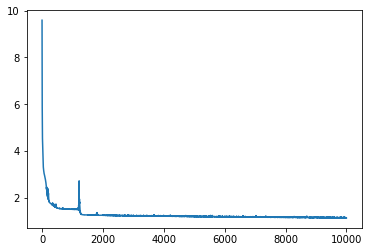

In [10]:
plt.plot(hist.history["loss"])

In [11]:
x = np.arange(-15.0, 15.0, 0.2)
y = np.arange(-15.0, 15.0, 0.2)
X, Y = np.meshgrid(x, y)
Z = model_train.predict([X.flatten().reshape((-1,1)), Y.flatten().reshape((-1,1))])
Z = Z.reshape(X.shape)

In [12]:
Z.shape

(150, 150)

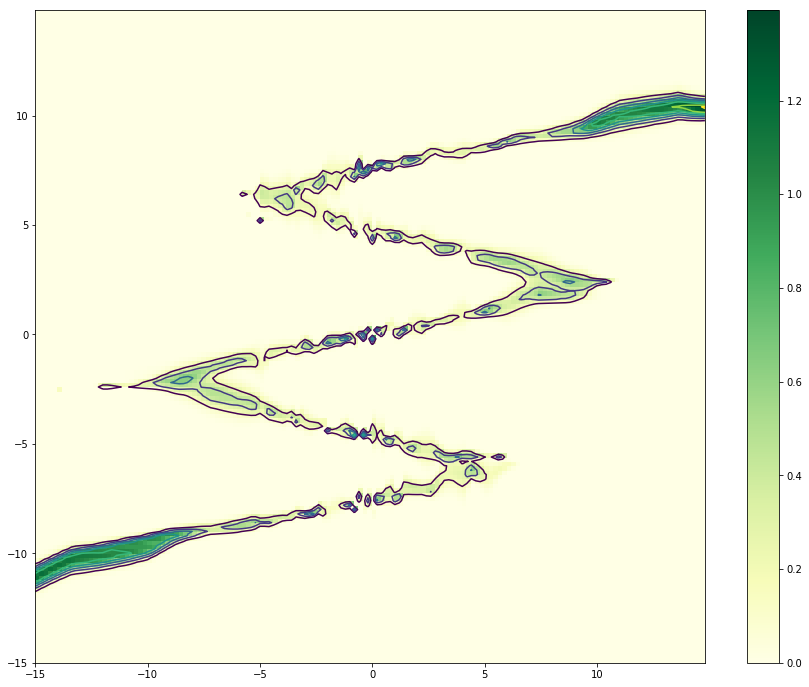

In [13]:
plt.figure(figsize=(15,12))
plt.pcolormesh(X,Y,Z,  cmap='YlGn')
plt.colorbar()
plt.contour(X, Y, Z)
plt.show()

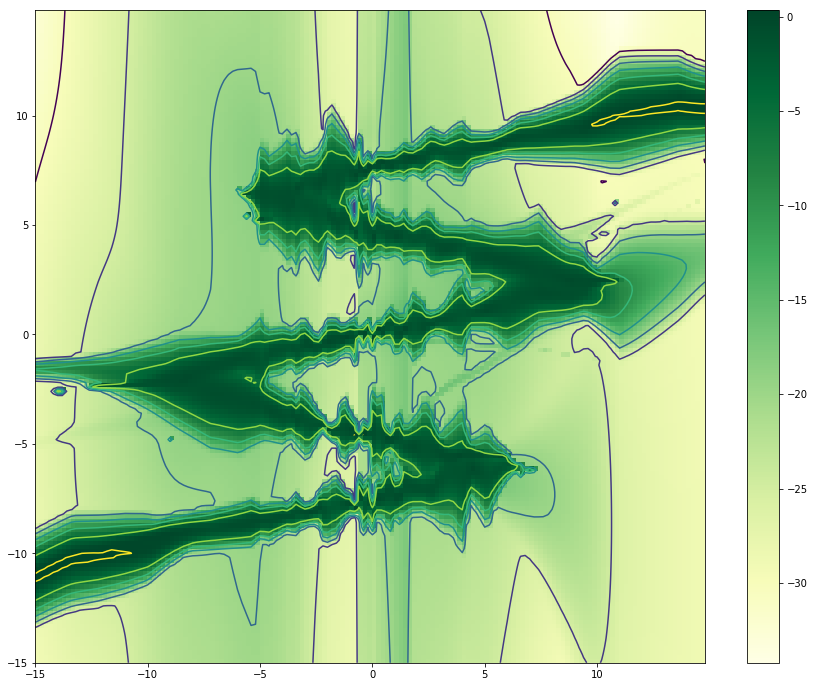

In [14]:
logZ = np.log(Z)
plt.figure(figsize=(15,12))
plt.pcolormesh(X,Y,logZ,  cmap='YlGn')
plt.colorbar()
plt.contour(X, Y, logZ)
plt.show()